
#Anomaly Detection Algorithm using Gaussian Mixture Model


*   Creator: Yunyi He

In [ ]:
%%shell
jupyter nbconvert --to html /PATH/TO/YOUR/NOTEBOOKFILE.ipynb

##Part 1: Exploratory Analysis

We are going to work with a credit card fraud dataset. This dataset contains 28 key features, which are not
directly interpretable but contain meaningful information about the dataset.

Load the dataset in CSV file using Pandas. The dataset is called `creditcard.csv`.

**284807 rows**

**Target column: Class**

**The target values give us the labels of the data. 1 means that this is a fraud transaction. 0 means that this is a non-fraudulent transaction**

In [ ]:
# pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import wget

wget.download('https://github.com/aps1070-2019/datasets/raw/master/creditcard.tar.gz','creditcard.tar.gz')

In [ ]:
!tar -zxvf creditcard.tar.gz

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
df = pd.read_csv('creditcard.csv')

In [ ]:
df

In [ ]:
df.groupby('Class').count()


In [ ]:
print(284315/284807*100)
print((1-284315/284807)*100)
print(99.827 -0.173)

99.82725143693798
0.17274856306200848
99.654


**Class 0 has 99.827%. Class 1 has 0.173%.**

**This data is considered unbalance becuase the difference in the percentage of entries for the two classes is 99.654%, which is huge.**

**Balance and Imbalance is important because most of the machine learning algorithms used for classification were designed around the assumption of an equal number of examples for each class. Imbalance data results in models to have poor predictive performance, specifically for the minority class. This class distribution could lead to overfitting to the higher perventage class (in this case, class 0), because the model look at the data and cleverly decide that the best thing to do is to always predict “Class-0” and achieve high accuracy.**

 **We should use the confusion matrix,for example, Precision and recall. We can also use F1 score and AUC to evaluate the model.**


Next, split the dataset into a training (65%), validation (20%) and testing set (15%). Set the random state to 40.

In [ ]:
### Split the data  ###

from sklearn.model_selection import train_test_split

feature_data = df[['V1','V2','V3','V4','V5','V6','V7','V8','V9','V10','V11','V12',\
                   'V13','V14','V15','V16','V17','V18','V19','V20','V21','V22',\
                   'V23','V24','V25','V26','V27','V28']]
target_data = df['Class']
# split data into train and val to 85- 15
X_train, X_test, y_train, y_test \
    = train_test_split(feature_data, target_data, test_size=0.15, random_state=40)

# split train into train and test to 65 - 20

X_train, X_val, y_train, y_val \
    = train_test_split(X_train, y_train, test_size=0.2/0.85, random_state=40) # 0.25 x 0.8 = 0.2



Now, let's take a look at the difference in distribution for some variables between fraudulent and non-fraudulent transactions:

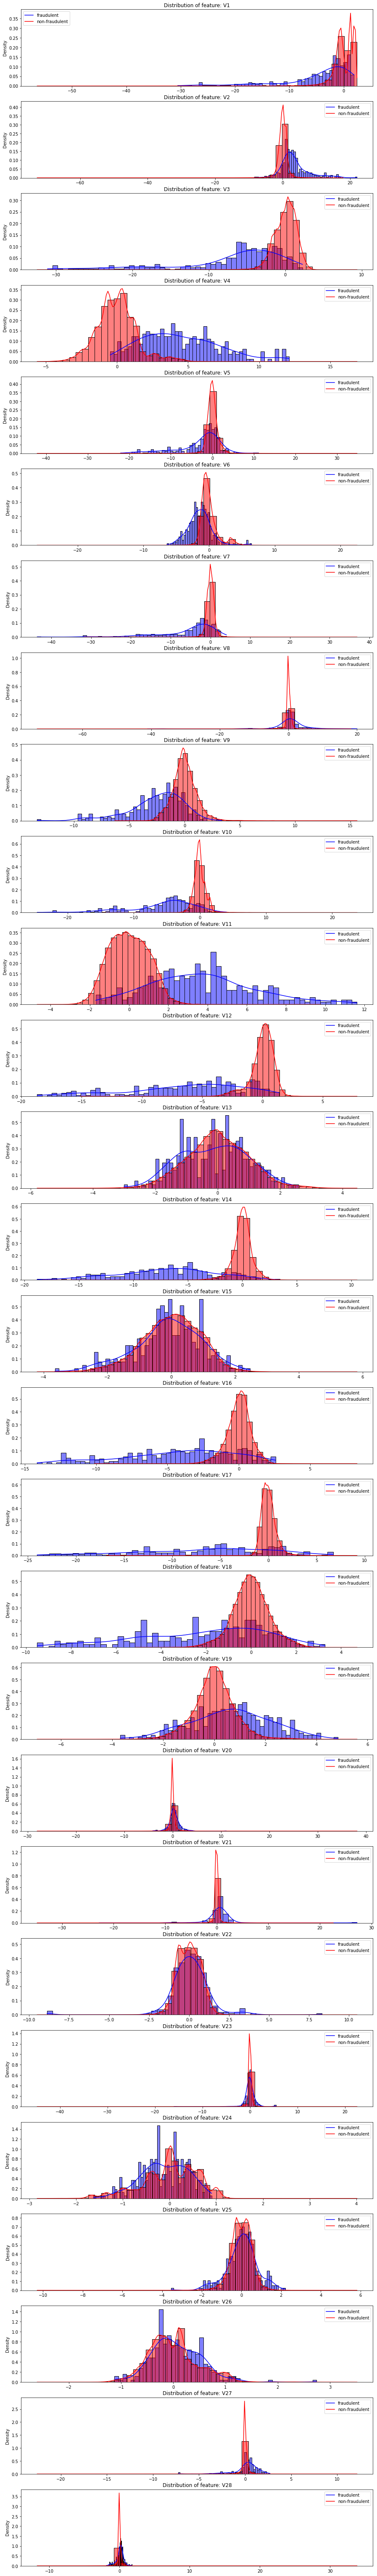

In [ ]:
import matplotlib.gridspec as gridspec
features=[f for f in df.columns if 'V' in f]
nplots=np.size(features)
plt.figure(figsize=(15,4*nplots))
gs = gridspec.GridSpec(nplots,1)
for i, feat in enumerate(features):
    ax = plt.subplot(gs[i])
    sns.histplot(X_train[feat][y_train==1], stat="density", kde=True, color="blue", bins=50)
    sns.histplot(X_train[feat][y_train==0], stat="density", kde=True, color="red", bins=50)
    ax.legend(['fraudulent', 'non-fraudulent'],loc='best')
    ax.set_xlabel('')
    ax.set_title('Distribution of feature: ' + feat)

**These graphs show that the distribution for all 28 features has a unimodal or bimodal distribution which different parameters (mean and variance). We can consider fitting the gaussian model with a different number of components. Some features have similar distributions for fraud and non-fraud transactions, such as features 15 and 22. Features such as 3,4,7,9,10,11,14 have distinct distributions for the two kinds of transaction. These features are more significant to include in the model to detect anomalies. We should consider fitting two gaussian models for the two kinds of transcations.**

##Part 2: One Gaussian model with Single feature:
We'll start by making a prediction using **a single feature of our dataset at a time**.

Please note that we **only use `V` features** in our model.

**a. Fitting regardless of class:**
  1. Fit a single Gaussian distribution on a single feature of **the full training dataset** (both classes) using ``sklearn.mixture.GaussianMixture`` when ``n_components=1``.
  2. Compute AUC (Area under the ROC Curve) based on ``sklearn.mixture.GaussianMixture.score_samples`` on both the full training set and validation set (including both classes).  
  3. Repeat the above steps for each of the features and present your findings in a table.
  4. Find the best 3 features to distinguish fraudulent transactions from non-fraudulent transactions based on the AUC of the validation set.
  5. Make a prediction based on a model's scores: If the `score_samples` is lower than a threshold, we consider that transaction as a fraud. Find an optimal threshold that maximizes the F1 Score of the validation set for each of those 3 features separately. (Do not check every possible value for threshold, come up with a faster way!) Compute F1 score using `sklearn.metrics.f1_score`.
  7. Report Precision, Recall and F1 score on both training and validation set in a table using the threshold you found in previous step.
  6. Report the complexity of your method (Big O notation) for determining the optimal threshold.

**b. Fitting based on class:**
 1. Pick 3 features that had the best AUC in Part 2a.
 2. repeat part 2a to compute AUC, F1 score, Precision and Recall when you fit a Gaussian **only on non-fraudulent transactions in the training set** in step 1 (instead of all the transactions).
 3. Compare results from parts 2a and 2b in a table (for both training and validation set).

In [ ]:
#a. Fitting regardless of class:

# 1. Fit a single Gaussian distribution on a single feature of the full training
# dataset (both classes) using sklearn.mixture.GaussianMixture when n_components=1.
from sklearn.mixture import GaussianMixture
from sklearn.metrics import roc_auc_score

single_train_auc =[]
single_valid_auc = []

#gm = GaussianMixture(n_components = 1,
 #                   covariance_type = 'full', random_state=0, )
for i in range(0,28):
  gm = GaussianMixture(n_components = 1,
                    covariance_type = 'full', random_state=0, )
  gm.fit(X_train[X_train.columns[i]].values.reshape(-1,1))
# 2. Compute AUC (Area under the ROC Curve) based on sklearn.mixture.GaussianMixture.score_samples \
# on both the full training set and validation set (including both classes).
  p_train_single = gm.score_samples(X_train[X_train.columns[i]].values.reshape(-1,1))
  single_train_auc.append(roc_auc_score(y_train, -1 * p_train_single))

  gm.fit(X_val[X_val.columns[i]].values.reshape(-1,1))
  p_val_single = gm.score_samples(X_val[X_val.columns[i]].values.reshape(-1,1))
  single_valid_auc.append(roc_auc_score(y_val,  -1 *p_val_single))



In [ ]:
# 3. Repeat the above steps for each of the features and present your findings in a table. [0.3]
single_auc = {'Training AUC (single feature)' : single_train_auc, 'Validating AUC(single feature)': single_valid_auc}

single_auc = pd.DataFrame(data = single_auc, index = X_train.columns)
single_auc

,Training AUC (single feature),Validating AUC(single feature)
V1,0.692540,0.715479
V2,0.848245,0.852803
V3,0.870004,0.857128
V4,0.889715,0.883307
V5,0.761153,0.781091
V6,0.727997,0.720870
V7,0.865497,0.887199
V8,0.774903,0.790148
V9,0.799279,0.794019
V10,0.910025,0.917275


In [ ]:
# Find the best 3 features to distinguish fraudulent transactions
# from non-fraudulent transactions based on the AUC of the validation set. [0.2]
sorted(single_valid_auc)[-1]
single_auc.sort_values('Validating AUC(single feature)', ascending=False)

,Training AUC (single feature),Validating AUC(single feature)
V14,0.948014,0.955037
V17,0.928937,0.925756
V10,0.910025,0.917275
V16,0.896384,0.896359
V12,0.911908,0.892824
V7,0.865497,0.887199
V4,0.889715,0.883307
V11,0.899131,0.880394
V21,0.812968,0.861044
V3,0.870004,0.857128


The best 3 features to distinguish fraudulent transactions from non-fraudulent transactions based on the AUC of the validation set are **V14, V17, V10**.

In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
# Make a prediction based on a model's scores:
# Find optimal threshold If the score_samples is lower than a threshold, we consider that transaction as a fraud.
# Find an optimal threshold that maximizes the F1 Score of the validation set for each of those 3 features separately.


precision_train =[]
recall_train=[]
f1_train = []
precision_val =[]
recall_val =[]
f1_val =[]

for v in ['V14', 'V17', 'V10']:
  max_f1 = 0
  tr=0

  gm.fit(X_train[v].values.reshape(-1,1))
  p_gm_val = gm.score_samples(X_val[v].values.reshape(-1,1))
  p_gm_train = gm.score_samples(X_train[v].values.reshape(-1,1))
  #find the optimal threshold that max F1 of the validation set
  for i in np.arange(1,len(p_gm_val),100):
    curr_tr = sorted(p_gm_val)[i] # We sort the points by probability
    # Compute F1 score using sklearn.metrics.f1_score.
    F1 = f1_score(y_val,p_gm_val <tr )
    if F1 > max_f1:
      max_f1 = F1
      tr = curr_tr

# report precision, recall and F1 on both training and validation set using the threshold
  precision_train.append(precision_score(y_train, p_gm_train < tr) )
  recall_train.append(recall_score(y_train, p_gm_train < tr) )
  f1_train.append(f1_score(y_train,p_gm_train <tr))
  precision_val.append(precision_score(y_val, p_gm_val < tr) )
  recall_val.append(recall_score(y_val, p_gm_val < tr) )
  f1_val.append(f1_score(y_val,p_gm_val <tr ))


In [ ]:
bothset = {'Precision_Train':precision_train, 'Precision_Val':precision_val,'Recall_train':recall_train, \
           'Recall_Val':recall_val, 'F1 Score_train': f1_train,'F1 Score_Val': f1_val\
           }
bothset_auc = pd.DataFrame(data = bothset, index = ['V14','V4','V17'])
bothset_auc

<bound method DataFrame.to_html of      Precision_Train  Precision_Val  Recall_train  Recall_Val  F1 Score_train  \
V14         0.366261       0.388060      0.748447    0.764706        0.491837   
V4          0.326440       0.328358      0.686335    0.647059        0.442442   
V17         0.140426       0.139303      0.307453    0.274510        0.192795   

     F1 Score_Val  
V14      0.514851  
V4       0.435644  
V17      0.184818  >


**The method has O(n^2log(n)))** \
There are n/100 iterations for the for loop. For each iteration of the for loop, the sorting algorithm has a runtime of (nlog(n)). Assume the function that calculates f1_score, has runtime n. Together they have a runtime of 3n. Then the code under the if condition, deletion, and appending to a list take constant time, with a runtime of 1.
The whole algorithm has a runtime of (n/100) * (nlog(n) + 3n + 1) = n^2log(n)/10 + 3n^2 + n/10, which is in O(n^2log(n)).

In [ ]:
num1 = 0
for i in y_train:
  if i == 1:
    num1+=1
num1

322

In [ ]:
X_train.shape

(185123, 28)

In [ ]:
# b

# fit a Guassian only on non fraud training set
train =  X_train.copy()
train['class'] = y_train
train = train.loc[train['class']==0]
train_class = train['class']
# train = train.drop(columns='class')

precision_train0 =[]
recall_train0=[]
f1_train0 = []
precision_val0 =[]
recall_val0 =[]
f1_val0 =[]
auc_train0 =[]
auc_val0 =[]

for v in ['V14', 'V17', 'V10']:
  max_f1 = 0
  tr=0

  gm = GaussianMixture(n_components = 1,
                    covariance_type = 'full', random_state=0 )
  # fit a Gaussian model only on non fraud transaction in the training set
  gm.fit(train[v].values.reshape(-1,1))

  p_gm_val = gm.score_samples(X_val[v].values.reshape(-1,1))
  p_gm_train = gm.score_samples(X_train[v].values.reshape(-1,1))
  #find the optimal threshold that max F1 of the validation set
  for i in np.arange(1,len(p_gm_val),100):
    curr_tr = sorted(p_gm_val)[i] # We sort the points by probability
    # Compute F1 score using sklearn.metrics.f1_score.
    F1 = f1_score(y_val,p_gm_val <tr )
    if F1 > max_f1:
      max_f1 = F1
      tr = curr_tr

# report precision, recall and F1 on both training and validation set using the threshold
  precision_train0.append(precision_score(y_train, p_gm_train < tr) )
  recall_train0.append(recall_score(y_train, p_gm_train < tr) )
  f1_train0.append(f1_score(y_train,p_gm_train <tr))
  precision_val0.append(precision_score(y_val, p_gm_val < tr) )
  recall_val0.append(recall_score(y_val, p_gm_val < tr) )
  f1_val0.append(f1_score(y_val,p_gm_val <tr ))
  auc_train0.append(roc_auc_score(y_train, -1 * p_gm_train))
  auc_val0.append(roc_auc_score(y_val, -1 * p_gm_val))

In [ ]:
train.shape

(184801, 29)

In [ ]:
bothset_auc['Precision_train (non fraud only)'] = precision_train0
bothset_auc['Precision_Val (non fraud only)'] = precision_val0
bothset_auc['F1 score_train(non fraud)'] = f1_train0
bothset_auc['F1 score_Val(non fraud)'] = f1_val0
bothset_auc['Recall_train(non fraud)'] = recall_train0
bothset_auc['Recall_Val(non fraud)'] = recall_val0
bothset_auc['AUC_train(non fraud)'] = auc_train0
bothset_auc['AUC_Val(non fraud)'] = auc_val0
print(bothset_auc.to_html)

<bound method DataFrame.to_html of      Precision_Train  Precision_Val  Recall_train  Recall_Val  F1 Score_train  \
V14         0.366261       0.388060      0.748447    0.764706        0.491837   
V4          0.326440       0.328358      0.686335    0.647059        0.442442   
V17         0.140426       0.139303      0.307453    0.274510        0.192795   

     F1 Score_Val  Precision_train (non fraud only)  \
V14      0.514851                          0.367378   
V4       0.435644                          0.325959   
V17      0.184818                          0.140625   

     Precision_Val (non fraud only)  F1 score_train(non fraud)  \
V14                        0.388060                   0.492843   
V4                         0.328358                   0.442000   
V17                        0.139303                   0.192982   

     F1 score_Val(non fraud)  Recall_train(non fraud)  Recall_Val(non fraud)  \
V14                 0.514851                 0.748447               0.7647

In [ ]:
from tabulate import tabulate

print(tabulate(bothset_auc, tablefmt = 'Markdown', headers='keys'))

       Precision_Train    Precision_Val    Recall_train    Recall_Val    F1 Score_train    F1 Score_Val    Precision_train (non fraud only)    Precision_Val (non fraud only)    F1 score_train(non fraud)    F1 score_Val(non fraud)    Recall_train(non fraud)    Recall_Val(non fraud)    AUC_train(non fraud)    AUC_Val(non fraud)
---  -----------------  ---------------  --------------  ------------  ----------------  --------------  ----------------------------------  --------------------------------  ---------------------------  -------------------------  -------------------------  -----------------------  ----------------------  --------------------
V14           0.366261         0.38806         0.748447      0.764706          0.491837        0.514851                            0.367378                          0.38806                      0.492843                   0.514851                   0.748447                 0.764706                0.948317              0.954915
V4            0.

3. There are very minor difference in results between 2a and 2b. For example, precision (train) in 2a(both class) is 0.366261 and precision_train in 2b is 0.367378. Many socres fitted on the validation set are the same between 2a and 2b.



4. **They are similar because the first model fitted on both fraud and non fraud has 185123 records and the secoond model fitted on the non-fraud only data has 184787 records. The unbalance nature of the data makes the differece between the two model to be small. Hence result from 2a and 2b are similar.**






##Part 3: One Gaussian model with multiple features:
This part is similar to Part 2, but here we will pick multiple features and set the number of components **visually**.

 1. Pick two features (say, f1 and f2).
 2. Scatter plot (plt.scatter) those features of the training set on a figure (f1 on the x-axis and f2 on the y-axis).
 3. On the scatter plot color the training set based on their class (non-fraudulents blue and fraudulents red).
 4. Based on your plots decide how many Gaussian components (``n_components``) you need to fit the data (focus on valid transactions).
 5. Fit your Gaussian model on the training set (all samples).
 6. Compute AUC on both training and validation sets
 7. Pick 3 new pair of features and repeat steps 2 to 6.
 8. Pick the set with the highest AUC on the validation set (out of the four sets that you tried.)
 9. Find a threshold to maximize your F1 Score on the validation set.
 10. Plot two seperate figures (one for the training data and one for the validation data) similar to step 3 and put a circle around outliers based on the threshold




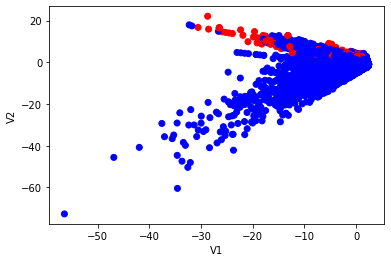

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

# 1. let f1 be V1 and f2 be V2
# 2. scatter plot
# 3. color by class
label = y_train
color = ['blue' if i == 0 else 'red'for i in y_train]

plt.scatter(x=X_train['V1'], y = X_train['V2'], c =color, label = label)
plt.xlabel('V1')
plt.ylabel('V2')
plt.show()

**Based on the plot, focusing on valid transaction, I decide to fit 2 Gaussian components (n_components =2), it seemes that there is a cluster on the V1 = -25 to 0. There is another cluster on V1=-40 to -24. They show obvious difference in density.**

In [ ]:
# 5. fit Gaussian model (n_components =2)on the training (all sample)
gm = GaussianMixture(n_components = 2,
                    covariance_type = 'full', random_state=0 )
train12 = X_train[['V1','V2']]
val12=X_val[['V1','V2']]

gm.fit(train12)
# 6. Compute AUC (Area under the ROC Curve)
# on both the full training set and validation set (including both classes).
p_train_single = gm.score_samples(train12)
auc = roc_auc_score(y_train, -1 * p_train_single)
print('AUC (training)for V1 and V2 is', auc)


gm.fit(val12)
p_val_single = gm.score_samples(val12)
auc_val = roc_auc_score(y_val,-1 *p_val_single)
print('AUC (validation) for V1 and V2 is', auc_val)


AUC (training)for V1 and V2 is 0.8841408759282815
AUC (validation) for V1 and V2 is 0.8809411488830495


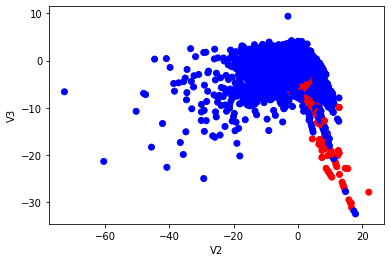

In [ ]:
# repeat above steps for 3 new pairs
# V2 and V3
# 3. color by class
plt.scatter(x=X_train['V2'], y = X_train['V3'], c =color, label = label)
plt.xlabel('V2')
plt.ylabel('V3')
plt.show()

**Based on the plot, focusing on valid transaction, I decide to fit 2 Gaussian components (n_components =2). There are difference in density of data. One difference is shown from the V2 = -40 to -20. Another density from V2= -21 to 16.**

In [ ]:
# 5. fit Gaussian model (n_components =2)on the training (all sample)
gm = GaussianMixture(n_components = 2,
                    covariance_type = 'full', random_state=0 )
train12 = X_train[['V2','V3']]
val12=X_val[['V2','V3']]

gm.fit(train12)
# 6. Compute AUC (Area under the ROC Curve)
# on both the full training set and validation set (including both classes).
p_train_single = gm.score_samples(train12)
auc = roc_auc_score(y_train, -1 * p_train_single)
print('AUC (training)for V2 and V3 is', auc)


gm.fit(val12)
p_val_single = gm.score_samples(val12)
auc_val = roc_auc_score(y_val,-1 *p_val_single)
print('AUC (validation) for V2 and V3 is', auc_val)

AUC (training)for V2 and V3 is 0.8955968617711695
AUC (validation) for V2 and V3 is 0.8908921465174181


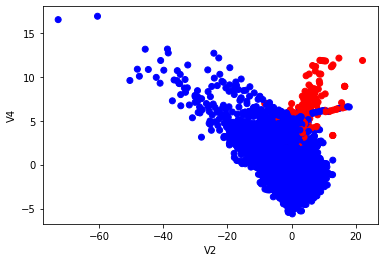

In [ ]:
# V2 and V4
# 3. color by class
plt.scatter(x=X_train['V2'], y = X_train['V4'], c =color, label = label)
plt.xlabel('V2')
plt.ylabel('V4')
plt.show()


**Based on the plot, focusing on valid transaction, I decide to fit 2 Gaussian components (n_components =2). There are difference in density of data. One difference is shown from the V2 = -40 to -20. Another density from v2= -21 to 15.**

In [ ]:
# 5. fit Gaussian model (n_components =2)on the training (all sample)
gm = GaussianMixture(n_components = 2,
                    covariance_type = 'full', random_state=0 )
train12 = X_train[['V2','V4']]
val12=X_val[['V2','V4']]

gm.fit(train12)
# 6. Compute AUC (Area under the ROC Curve)
# on both the full training set and validation set (including both classes).
p_train_single = gm.score_samples(train12)
auc = roc_auc_score(y_train, -1 * p_train_single)
print('AUC (training)for V2 and V4 is', auc)


gm.fit(val12)
p_val_single = gm.score_samples(val12)
auc_val = roc_auc_score(y_val,-1 *p_val_single)
print('AUC (validation) for V2 and V4 is', auc_val)

AUC (training)for V2 and V4 is 0.902109978230402
AUC (validation) for V2 and V4 is 0.8907493810046001


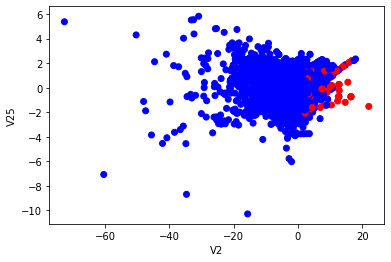

In [ ]:
# V2 and V25
# 3. color by class
plt.scatter(x=X_train['V2'], y = X_train['V25'], c =color, label = label)
plt.xlabel('V2')
plt.ylabel('V25')
plt.show()

**Based on the plot, focusing on valid transaction, I decide to fit 2 Gaussian components (n_components =2). There are difference in density of data. One difference is shown from the V2 = -55 to -20. Another density from v2= -21 to 10.**

In [ ]:
# 5. fit Gaussian model (n_components =1)on the training (all sample)
gm = GaussianMixture(n_components = 2,
                    covariance_type = 'full', random_state=0 )
train12 = X_train[['V2','V25']]
val12=X_val[['V2','V25']]

gm.fit(train12)
# 6. Compute AUC (Area under the ROC Curve)
# on both the full training set and validation set (including both classes).
p_train_single = gm.score_samples(train12)
auc = roc_auc_score(y_train, -1 * p_train_single)
print('AUC (training)for V2 and V25 is', auc)


gm.fit(val12)
p_val_single = gm.score_samples(val12)
auc_val = roc_auc_score(y_val,-1 *p_val_single)
print('AUC (validation) for V2 and V25 is', auc_val)

AUC (training)for V2 and V25 is 0.829094455506462
AUC (validation) for V2 and V25 is 0.8455573717351872


**AUC (validation) for V2 and V3 is 0.8908921465174181, which is the highest among the four sets.**

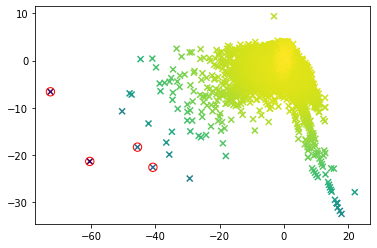

In [ ]:
# find tr that max F1 on the validation set

train12 = np.array(X_train[['V2','V3']])
val12=np.array(X_val[['V2','V3']])
gm = GaussianMixture(n_components = 2,
                    covariance_type = 'full', random_state=0 )
gm.fit(train12)
# 6. Compute AUC (Area under the ROC Curve)
# on both the full training set and validation set (including both classes).
p_gm_val = gm.score_samples(val12)
p_gm_train = gm.score_samples(train12)
tr =0
max_f1 = 0
for i in np.arange(1,len(p_gm_val),100):
  curr_tr = sorted(p_gm_val)[i] # We sort the points by probability
  # Compute F1 score using sklearn.metrics.f1_score.
  F1 = f1_score(y_val,p_gm_val <tr )
  if F1 > max_f1:
    max_f1 = F1
    tr = curr_tr

# tr = -453.8947770795851
# Plot two seperate figures (one for the training data and one for the
# validation data) similar to step 3 and put a circle around outliers based on your threshold
# plot for training
plt.scatter(X_train['V2'],X_train['V3'],marker="x",c=p_gm_train,cmap='viridis');
outliers = np.nonzero(p_gm_train < tr)[0]
plt.scatter(train12[outliers,0],train12[outliers,1],marker="o",facecolor= "none",edgecolor="r",s=70)
plt.show()


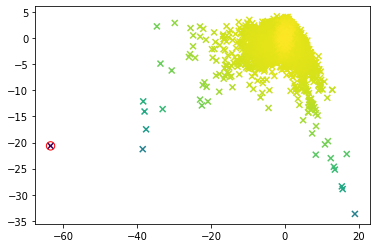

In [ ]:
# plot for testing
plt.scatter(X_val['V2'],X_val['V3'],marker="x",c=p_gm_val,cmap='viridis');
outliers = np.nonzero(p_gm_val < tr)[0]
plt.scatter(val12[outliers,0],val12[outliers,1],marker="o",facecolor= "none",edgecolor="r",s=70)
plt.show()

## **Part 4:  Two Gaussian model with single feature. **
Now we will use two separate distributions for fraudulent and non-fraudulent transactions.
  1.  Fit a Gaussian distribution ($G_1$) on a feature of **non-fraudulent transactions** using ``sklearn.mixture.GaussianMixture`` when ``n_components=1``.
  2. Fit another Gaussian distribution ($G_2$) on the same feature but for **fraudulent transactions** using ``sklearn.mixture.GaussianMixture`` when ``n_components=1``.
  3. Compute the score samples ($S$) for both $G_1$ and $G_2$ on the **validation set** to get $S_1$ and $S_2$, respectively.
  4. Find an optimal $c$ (a real number) that maximizes validation set F1 Score for a model such that if $S_1 < c \times S_2$, the transaction is classified as a fraud. For example, if $c=1$ we could say that if $S_2$ is greater than $S_1$, ($S_1$<$S_2$) then the transaction is a fraud (the transaction belongs to the $G_2$ distribution which represents fraudulent transactions). For start consider $c$ in $[0,10]$ with steps of 0.1, you can change this window in your experiments if needed.
  5. Repeat the steps above for all the features. What is the best F1 Score, Precision and Recall that you get for training and validation? Which feature and what c?

In [ ]:
f1_train = []
pre_train =[]
re_train =[]
f1_val = []
pre_val =[]
re_val =[]
cs=[]

for i in range(0,28):
  # 1. Fit a Gaussian distribution ( 𝐺1 ) on a feature of non-fraudulent
  # transactions using sklearn.mixture.GaussianMixture when n_components=1.
  train =  X_train.copy()
  train['class'] = y_train
  train0 = train.loc[train['class']==0][X_train.columns[i]]
  train1 = train.loc[train['class']==1][X_train.columns[i]]

  # val =  X_val.copy()
  # val['class'] = y_val
  # val0 = val.loc[val['class']==0]['V1']
  # val1 = val.loc[val['class']==1]['V1']

  G1= GaussianMixture(n_components = 1,
                      covariance_type = 'full', random_state=0, )
  G1.fit(train0.values.reshape(-1,1))

  G2= GaussianMixture(n_components = 1,
                      covariance_type = 'full', random_state=0, )
  G2.fit(train1.values.reshape(-1,1))

  # 3. Compute the score samples ( 𝑆 ) for both  𝐺1  and  𝐺2  on the
  # validation set to get  𝑆1  and  𝑆2 , respectively.
  S1 = G1.score_samples(X_val[X_val.columns[i]].values.reshape(-1,1))
  S2 = G2.score_samples(X_val[X_val.columns[i]].values.reshape(-1,1))
  S1_train = G1.score_samples(X_train[X_train.columns[i]].values.reshape(-1,1))
  S2_train = G2.score_samples(X_train[X_train.columns[i]].values.reshape(-1,1))

  # 4. 𝑆1<𝑐×𝑆2. If cxS2 graeter than S1, than the transaction is fraud （1）
  max_f1 =0

  # Find an optimal  𝑐  (a real number) that maximizes validation set F1 Score
  # for a model such that if  𝑆1<𝑐×𝑆2 , the transaction is classified as a fraud.
  for c in np.arange(0,10,0.1):
    f1=f1_score(y_val, S1<c*S2)
    if f1>max_f1:
      max_f1 = f1
      opt_c = c

  pre_train.append(precision_score(y_train, S1_train<opt_c*S2_train) )
  re_train.append(recall_score(y_train, S1_train<opt_c*S2_train) )
  f1_train.append(f1_score(y_train,S1_train<opt_c*S2_train))
  pre_val.append(precision_score(y_val, S1<opt_c*S2) )
  re_val.append(recall_score(y_val, S1<opt_c*S2))
  f1_val.append(f1_score(y_val,S1<opt_c*S2 ))
  cs.append(opt_c)


In [ ]:
table2 = {'best F1(train)': f1_train, 'best F1(Val)':f1_val, 'precison(train)': pre_train, "precision(Val)":pre_val,\
                      "recall(train)": re_train, 'recall(Val)':re_val, 'Opt C': cs}
table3 = pd.DataFrame(data= table2, index = X_train.columns)
table3.sort_values('best F1(Val)', ascending=False)


<bound method DataFrame.to_html of      best F1(train)  best F1(Val)  precison(train)  precision(Val)  \
V17        0.625592      0.670157         0.636656        0.719101   
V12        0.673540      0.662857         0.753846        0.794521   
V14        0.616766      0.660194         0.595376        0.653846   
V11        0.585789      0.627907         0.662745        0.771429   
V16        0.565815      0.569697         0.770053        0.746032   
V18        0.424107      0.452555         0.753968        0.885714   
V9         0.406321      0.448980         0.743802        0.733333   
V10        0.383803      0.397590         0.443089        0.515625   
V4         0.355958      0.377358         0.346041        0.363636   
V3         0.268714      0.312139         0.351759        0.380282   
V7         0.236364      0.236967         0.230769        0.229358   
V5         0.164706      0.193939         0.223404        0.253968   
V2         0.127778      0.175439         0.605263     

In [ ]:
S2

array([-8.32709389, -7.04862746, -7.6497759 , ..., -8.81832221,
       -7.62362231, -7.46866381])

For validation set, the best F1 score is 0.670157, it is V17. The corresponding c is 5.9. Its precision_val is 0.719101. Its recall_val is 0.627451.


**We cannot report AUC for this model using the function roc_auc_score because this function only takes in one set of values (one set of score sample). But, here we fitted two guassian models and have 2 sets of values (i.e 2 sets of score samples), S1 and S2. However, the function roc_auc_score can only take in one dimention floats (one score sample).**

##Part 5: Multivariate and Mixture of Gaussians Distribution
We now want to build an outlier detection model that performs well in terms of F1 score.

In [ ]:
# one guassian, 1 feature V17, 1 component
precision_train =[]
recall_train=[]
f1_train = []
precision_val =[]
recall_val =[]
f1_val =[]
single_train_auc=[]
single_valid_auc =[]
index =[]

max_f1 = 0
tr=0
gm = GaussianMixture(n_components = 1,
                  covariance_type = 'full', random_state=0, )
gm.fit(X_train['V17'].values.reshape(-1,1))
p_gm_val = gm.score_samples(X_val['V17'].values.reshape(-1,1))
p_gm_train = gm.score_samples(X_train['V17'].values.reshape(-1,1))
#find the optimal threshold that max F1 of the validation set
for i in np.arange(1,len(p_gm_val),100):
  curr_tr = sorted(p_gm_val)[i] # We sort the points by probability
  # Compute F1 score using sklearn.metrics.f1_score.
  F1 = f1_score(y_val,p_gm_val <tr )
  if F1 > max_f1:
    max_f1 = F1
    tr = curr_tr

# report precision, recall and F1 on both training and validation set using the threshold
precision_train.append(precision_score(y_train, p_gm_train < tr) )
recall_train.append(recall_score(y_train, p_gm_train < tr) )
f1_train.append(f1_score(y_train,p_gm_train <tr))
precision_val.append(precision_score(y_val, p_gm_val < tr) )
recall_val.append(recall_score(y_val, p_gm_val < tr) )
f1_val.append(f1_score(y_val,p_gm_val <tr ))
# 2. Compute AUC (Area under the ROC Curve) based on sklearn.mixture.GaussianMixture.score_samples \
# on both the full training set and validation set (including both classes).
single_train_auc.append(roc_auc_score(y_train, -1 * p_gm_train))
single_valid_auc.append(roc_auc_score(y_val,  -1 *p_gm_val))


index.append('1,1,1')
bothset = {'Precision_Train':precision_train, 'Precision_Val':precision_val,'Recall_train':recall_train, \
          'Recall_Val':recall_val, 'F1 Score_train': f1_train,'F1 Score_Val': f1_val,\
          'AUC_training' : single_train_auc, ' AUC_Val': single_valid_auc
          }
bothset_auc = pd.DataFrame(data = bothset, index = index)
bothset_auc




,Precision_Train,Precision_Val,Recall_train,Recall_Val,F1 Score_train,F1 Score_Val,AUC_training,AUC_Val
"1,1,1",0.32644,0.328358,0.686335,0.647059,0.442442,0.435644,0.928937,0.925698


In [ ]:
# 2.ono guassians, ['V17','V12','V14','V11'] , 1 component
max_f1 = 0
tr=0
gm = GaussianMixture(n_components = 1,
                  covariance_type = 'full', random_state=0, )
gm.fit(X_train[['V17','V12','V14','V11']])
p_gm_val = gm.score_samples(X_val[['V17','V12','V14','V11']])
p_gm_train = gm.score_samples(X_train[['V17','V12','V14','V11']])
#find the optimal threshold that max F1 of the validation set
for i in np.arange(1,len(p_gm_val),100):
  curr_tr = sorted(p_gm_val)[i] # We sort the points by probability
  # Compute F1 score using sklearn.metrics.f1_score.
  F1 = f1_score(y_val,p_gm_val <tr )
  if F1 > max_f1:
    max_f1 = F1
    tr = curr_tr

# 2. Compute AUC (Area under the ROC Curve) based on sklearn.mixture.GaussianMixture.score_samples \
# on both the full training set and validation set (including both classes).
single_train_auc.append(roc_auc_score(y_train, -1 * p_gm_train))
single_valid_auc.append(roc_auc_score(y_val,  -1 *p_gm_val))


# report precision, recall and F1 on both training and validation set using the threshold
precision_train.append(precision_score(y_train, p_gm_train < tr) )
recall_train.append(recall_score(y_train, p_gm_train < tr) )
f1_train.append(f1_score(y_train,p_gm_train <tr))
precision_val.append(precision_score(y_val, p_gm_val < tr) )
recall_val.append(recall_score(y_val, p_gm_val < tr) )
f1_val.append(f1_score(y_val,p_gm_val <tr ))
index.append('1,4,1')
bothset = {'Precision_Train':precision_train, 'Precision_Val':precision_val,'Recall_train':recall_train, \
          'Recall_Val':recall_val, 'F1 Score_train': f1_train,'F1 Score_Val': f1_val,\
          'AUC_training' : single_train_auc, ' AUC_Val': single_valid_auc
          }
bothset_auc = pd.DataFrame(data = bothset, index = index)
bothset_auc




ValueError: ignored

In [ ]:
# 3.One gaussians, ['V17','V12','V14'], 1 component
max_f1 = 0
tr=0
gm = GaussianMixture(n_components = 1,
                  covariance_type = 'full', random_state=0, )
gm.fit(X_train[['V17','V12','V14']])
p_gm_val = gm.score_samples(X_val[['V17','V12','V14']])
p_gm_train = gm.score_samples(X_train[['V17','V12','V14']])
#find the optimal threshold that max F1 of the validation set
for i in np.arange(1,len(p_gm_val),100):
  curr_tr = sorted(p_gm_val)[i] # We sort the points by probability
  # Compute F1 score using sklearn.metrics.f1_score.
  F1 = f1_score(y_val,p_gm_val <tr )
  if F1 > max_f1:
    max_f1 = F1
    tr = curr_tr

# 2. Compute AUC (Area under the ROC Curve) based on sklearn.mixture.GaussianMixture.score_samples \
# on both the full training set and validation set (including both classes).
single_train_auc.append(roc_auc_score(y_train, -1 * p_gm_train))
single_valid_auc.append(roc_auc_score(y_val,  -1 *p_gm_val))


# report precision, recall and F1 on both training and validation set using the threshold
precision_train.append(precision_score(y_train, p_gm_train < tr) )
recall_train.append(recall_score(y_train, p_gm_train < tr) )
f1_train.append(f1_score(y_train,p_gm_train <tr))
precision_val.append(precision_score(y_val, p_gm_val < tr) )
recall_val.append(recall_score(y_val, p_gm_val < tr) )
f1_val.append(f1_score(y_val,p_gm_val <tr ))
index.append('1,3,1')
bothset = {'Precision_Train':precision_train, 'Precision_Val':precision_val,'Recall_train':recall_train, \
          'Recall_Val':recall_val, 'F1 Score_train': f1_train,'F1 Score_Val': f1_val,\
          'AUC_training' : single_train_auc, ' AUC_Val': single_valid_auc
          }
bothset_auc = pd.DataFrame(data = bothset, index = index)
bothset_auc





In [ ]:
# 4. One guassians, one feature V17, 2 component
max_f1 = 0
tr=0
gm = GaussianMixture(n_components = 2,
                  covariance_type = 'full', random_state=0, )
gm.fit(X_train['V17'].values.reshape(-1,1))
p_gm_val = gm.score_samples(X_val['V17'].values.reshape(-1,1))
p_gm_train = gm.score_samples(X_train['V17'].values.reshape(-1,1))
#find the optimal threshold that max F1 of the validation set
for i in np.arange(1,len(p_gm_val),100):
  curr_tr = sorted(p_gm_val)[i] # We sort the points by probability
  # Compute F1 score using sklearn.metrics.f1_score.
  F1 = f1_score(y_val,p_gm_val <tr )
  if F1 > max_f1:
    max_f1 = F1
    tr = curr_tr

# 2. Compute AUC (Area under the ROC Curve) based on sklearn.mixture.GaussianMixture.score_samples \
# on both the full training set and validation set (including both classes).
single_train_auc.append(roc_auc_score(y_train, -1 * p_gm_train))
single_valid_auc.append(roc_auc_score(y_val,  -1 *p_gm_val))


# report precision, recall and F1 on both training and validation set using the threshold
precision_train.append(precision_score(y_train, p_gm_train < tr) )
recall_train.append(recall_score(y_train, p_gm_train < tr) )
f1_train.append(f1_score(y_train,p_gm_train <tr))
precision_val.append(precision_score(y_val, p_gm_val < tr) )
recall_val.append(recall_score(y_val, p_gm_val < tr) )
f1_val.append(f1_score(y_val,p_gm_val <tr ))
index.append('1,1,2')
bothset = {'Precision_Train':precision_train, 'Precision_Val':precision_val,'Recall_train':recall_train, \
          'Recall_Val':recall_val, 'F1 Score_train': f1_train,'F1 Score_Val': f1_val,\
          'AUC_training' : single_train_auc, ' AUC_Val': single_valid_auc
          }
bothset_auc = pd.DataFrame(data = bothset, index = index)
bothset_auc







In [ ]:
# 5.ono guassians, ['V17','V12','V14','V11'] , 2 component
max_f1 = 0
tr=0
gm = GaussianMixture(n_components = 2,
                  covariance_type = 'full', random_state=0, )
gm.fit(X_train[['V17','V12','V14','V11']])
p_gm_val = gm.score_samples(X_val[['V17','V12','V14','V11']])
p_gm_train = gm.score_samples(X_train[['V17','V12','V14','V11']])
#find the optimal threshold that max F1 of the validation set
for i in np.arange(1,len(p_gm_val),100):
  curr_tr = sorted(p_gm_val)[i] # We sort the points by probability
  # Compute F1 score using sklearn.metrics.f1_score.
  F1 = f1_score(y_val,p_gm_val <tr )
  if F1 > max_f1:
    max_f1 = F1
    tr = curr_tr

# Compute AUC (Area under the ROC Curve) based on sklearn.mixture.GaussianMixture.score_samples \
# on both the full training set and validation set (including both classes).
single_train_auc.append(roc_auc_score(y_train, -1 * p_gm_train))
single_valid_auc.append(roc_auc_score(y_val,  -1 *p_gm_val))


# report precision, recall and F1 on both training and validation set using the threshold
precision_train.append(precision_score(y_train, p_gm_train < tr) )
recall_train.append(recall_score(y_train, p_gm_train < tr) )
f1_train.append(f1_score(y_train,p_gm_train <tr))
precision_val.append(precision_score(y_val, p_gm_val < tr) )
recall_val.append(recall_score(y_val, p_gm_val < tr) )
f1_val.append(f1_score(y_val,p_gm_val <tr ))
index.append('1,4,2')
bothset = {'Precision_Train':precision_train, 'Precision_Val':precision_val,'Recall_train':recall_train, \
          'Recall_Val':recall_val, 'F1 Score_train': f1_train,'F1 Score_Val': f1_val,\
          'AUC_training' : single_train_auc, ' AUC_Val': single_valid_auc
          }
bothset_auc = pd.DataFrame(data = bothset, index = index)
bothset_auc




,Precision_Train,Precision_Val,Recall_train,Recall_Val,F1 Score_train,F1 Score_Val,AUC_training,AUC_Val
"1,1,1",0.326440,0.328358,0.686335,0.647059,0.442442,0.435644,0.928937,0.925698
"1,4,1",0.403933,0.407960,0.829193,0.803922,0.543235,0.541254,0.959748,0.951506
"1,3,1",0.403933,0.407960,0.829193,0.803922,0.543235,0.541254,0.959748,0.951506
"1,1,2",0.372881,0.357143,0.751553,0.686275,0.498455,0.469799,0.931409,0.927802
"1,4,2",0.366197,0.388060,0.807453,0.764706,0.503876,0.514851,0.961000,0.955536


In [ ]:
# 6.One gaussians, ['V17','V12','V14'], 2 component
max_f1 = 0
tr=0
gm = GaussianMixture(n_components = 2,
                  covariance_type = 'full', random_state=0, )
gm.fit(X_train[['V17','V12','V14']])
p_gm_val = gm.score_samples(X_val[['V17','V12','V14']])
p_gm_train = gm.score_samples(X_train[['V17','V12','V14']])
#find the optimal threshold that max F1 of the validation set
for i in np.arange(1,len(p_gm_val),100):
  curr_tr = sorted(p_gm_val)[i] # We sort the points by probability
  # Compute F1 score using sklearn.metrics.f1_score.
  F1 = f1_score(y_val,p_gm_val <tr )
  if F1 > max_f1:
    max_f1 = F1
    tr = curr_tr

# 2. Compute AUC (Area under the ROC Curve) based on sklearn.mixture.GaussianMixture.score_samples \
# on both the full training set and validation set (including both classes).
single_train_auc.append(roc_auc_score(y_train, -1 * p_gm_train))
single_valid_auc.append(roc_auc_score(y_val,  -1 *p_gm_val))


# report precision, recall and F1 on both training and validation set using the threshold
precision_train.append(precision_score(y_train, p_gm_train < tr) )
recall_train.append(recall_score(y_train, p_gm_train < tr) )
f1_train.append(f1_score(y_train,p_gm_train <tr))
precision_val.append(precision_score(y_val, p_gm_val < tr) )
recall_val.append(recall_score(y_val, p_gm_val < tr) )
f1_val.append(f1_score(y_val,p_gm_val <tr ))
index.append('1,3,2')
bothset = {'Precision_Train':precision_train, 'Precision_Val':precision_val,'Recall_train':recall_train, \
          'Recall_Val':recall_val, 'F1 Score_train': f1_train,'F1 Score_Val': f1_val,\
          'AUC_training' : single_train_auc, ' AUC_Val': single_valid_auc
          }
bothset_auc = pd.DataFrame(data = bothset, index = index)
bothset_auc





,Precision_Train,Precision_Val,Recall_train,Recall_Val,F1 Score_train,F1 Score_Val,AUC_training,AUC_Val
"1,1,1",0.326440,0.328358,0.686335,0.647059,0.442442,0.435644,0.928937,0.925698
"1,4,1",0.403933,0.407960,0.829193,0.803922,0.543235,0.541254,0.959748,0.951506
"1,3,1",0.403933,0.407960,0.829193,0.803922,0.543235,0.541254,0.959748,0.951506
"1,1,2",0.372881,0.357143,0.751553,0.686275,0.498455,0.469799,0.931409,0.927802
"1,4,2",0.366197,0.388060,0.807453,0.764706,0.503876,0.514851,0.961000,0.955536
"1,3,2",0.372857,0.393035,0.810559,0.774510,0.510763,0.521452,0.959104,0.956637


In [ ]:
# 7.two gaussian model, one feature v17, 1 componenet

# 1. Fit a Gaussian distribution ( 𝐺1 ) on a feature of non-fraudulent
# transactions using sklearn.mixture.GaussianMixture when n_components=1.
train =  X_train.copy()
train['class'] = y_train
train0 = train.loc[train['class']==0]['V17']
train1 = train.loc[train['class']==1]['V17']

G1= GaussianMixture(n_components = 1,
                    covariance_type = 'full', random_state=0, )
G1.fit(train0.values.reshape(-1,1))

G2= GaussianMixture(n_components = 1,
                    covariance_type = 'full', random_state=0, )
G2.fit(train1.values.reshape(-1,1))

# 3. Compute the score samples ( 𝑆 ) for both  𝐺1  and  𝐺2  on the
# validation set to get  𝑆1  and  𝑆2 , respectively.
S1 = G1.score_samples(X_val['V17'].values.reshape(-1,1))
S2 = G2.score_samples(X_val['V17'].values.reshape(-1,1))
S1_train = G1.score_samples(X_train['V17'].values.reshape(-1,1))
S2_train = G2.score_samples(X_train['V17'].values.reshape(-1,1))

# 4. 𝑆1<𝑐×𝑆2. If cxS2 graeter than S1, than the transaction is fraud （1）
max_f1 =0

# Find an optimal  𝑐  (a real number) that maximizes validation set F1 Score
# for a model such that if  𝑆1<𝑐×𝑆2 , the transaction is classified as a fraud.
for c in np.arange(0,10,0.1):
  f1=f1_score(y_val, S1<c*S2)
  if f1>max_f1:
    max_f1 = f1
    opt_c = c

# report precision, recall and F1 on both training and validation set using the threshold
precision_train.append(precision_score(y_train, S1_train<opt_c*S2_train) )
recall_train.append(recall_score(y_train, S1_train<opt_c*S2_train) )
f1_train.append(f1_score(y_train,S1_train<opt_c*S2_train))
precision_val.append(precision_score(y_val, S1<c*S2) )
recall_val.append(recall_score(y_val, S1<c*S2) )
f1_val.append(f1_score(y_val,S1<c*S2 ))
single_train_auc.append('na')
single_valid_auc.append('na')

index.append('2,1,1')
bothset = {'Precision_Train':precision_train, 'Precision_Val':precision_val,'Recall_train':recall_train, \
          'Recall_Val':recall_val, 'F1 Score_train': f1_train,'F1 Score_Val': f1_val,\
          'AUC_training' : single_train_auc, ' AUC_Val': single_valid_auc
          }
bothset_auc = pd.DataFrame(data = bothset, index = index)
bothset_auc


In [ ]:
# 8.two gaussian model, one feature v17, 2 componenet

# 1. Fit a Gaussian distribution ( 𝐺1 ) on a feature of non-fraudulent
# transactions using sklearn.mixture.GaussianMixture when n_components=1.
train =  X_train.copy()
train['class'] = y_train
train0 = train.loc[train['class']==0]['V17']
train1 = train.loc[train['class']==1]['V17']

G1= GaussianMixture(n_components = 2,
                    covariance_type = 'full', random_state=0, )
G1.fit(train0.values.reshape(-1,1))

G2= GaussianMixture(n_components = 2,
                    covariance_type = 'full', random_state=0, )
G2.fit(train0.values.reshape(-1,1))
# 3. Compute the score samples ( 𝑆 ) for both  𝐺1  and  𝐺2  on the
# validation set to get  𝑆1  and  𝑆2 , respectively.
S1 = G1.score_samples(X_val['V17'].values.reshape(-1,1))
S2 = G2.score_samples(X_val['V17'].values.reshape(-1,1))
S1_train = G1.score_samples(X_train['V17'].values.reshape(-1,1))
S2_train = G2.score_samples(X_train['V17'].values.reshape(-1,1))

# 4. 𝑆1<𝑐×𝑆2. If cxS2 graeter than S1, than the transaction is fraud （1）
max_f1 =0

# Find an optimal  𝑐  (a real number) that maximizes validation set F1 Score
# for a model such that if  𝑆1<𝑐×𝑆2 , the transaction is classified as a fraud.
for c in np.arange(0,10,0.1):
  f1=f1_score(y_val, S1<c*S2)
  if f1>max_f1:
    max_f1 = f1
    opt_c = c

# report precision, recall and F1 on both training and validation set using the threshold
precision_train.append(precision_score(y_train, S1_train<opt_c*S2_train) )
recall_train.append(recall_score(y_train, S1_train<opt_c*S2_train) )
f1_train.append(f1_score(y_train,S1_train<opt_c*S2_train))
precision_val.append(precision_score(y_val, S1<c*S2) )
recall_val.append(recall_score(y_val, S1<c*S2) )
f1_val.append(f1_score(y_val,S1<c*S2 ))
single_train_auc.append('na')
single_valid_auc.append('na')

index.append('2,1,22')
bothset = {'Precision_Train':precision_train, 'Precision_Val':precision_val,'Recall_train':recall_train, \
          'Recall_Val':recall_val, 'F1 Score_train': f1_train,'F1 Score_Val': f1_val,\
          'AUC_training' : single_train_auc, ' AUC_Val': single_valid_auc
          }
bothset_auc = pd.DataFrame(data = bothset, index = index)
bothset_auc



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Precision_Train,Precision_Val,Recall_train,Recall_Val,F1 Score_train,F1 Score_Val,AUC_training,AUC_Val
"1,1,1",0.326440,0.328358,0.686335,0.647059,0.442442,0.435644,0.928937,0.925698
"1,4,1",0.403933,0.407960,0.829193,0.803922,0.543235,0.541254,0.959748,0.951506
"1,3,1",0.403933,0.407960,0.829193,0.803922,0.543235,0.541254,0.959748,0.951506
"1,1,2",0.372881,0.357143,0.751553,0.686275,0.498455,0.469799,0.931409,0.927802
"1,4,2",0.366197,0.388060,0.807453,0.764706,0.503876,0.514851,0.961,0.955536
"1,3,2",0.372857,0.393035,0.810559,0.774510,0.510763,0.521452,0.959104,0.956637
"2,1,22",0.001739,0.000000,1.000000,0.000000,0.003473,0.000000,na,na


In [ ]:
# 9.two gaussian model, multiple featuresv ['V17','V12','V14','V11'], one component for both

# 1. Fit a Gaussian distribution ( 𝐺1 ) on a feature of non-fraudulent
# transactions using sklearn.mixture.GaussianMixture when n_components=1.
train =  X_train.copy()
train['class'] = y_train
train0 = train.loc[train['class']==0]
train1 = train.loc[train['class']==1]

# val =  X_val.copy()
# val['class'] = y_val
# val0 = val.loc[val['class']==0]['V1']
# val1 = val.loc[val['class']==1]['V1']

G1= GaussianMixture(n_components = 1,
                    covariance_type = 'full', random_state=0, )
G1.fit(train0[['V17','V12','V14','V11']])

G2= GaussianMixture(n_components = 1,
                    covariance_type = 'full', random_state=0, )
G2.fit(train1[['V17','V12','V14','V11']])

# 3. Compute the score samples ( 𝑆 ) for both  𝐺1  and  𝐺2  on the
# validation set to get  𝑆1  and  𝑆2 , respectively.
S1 = G1.score_samples(X_val[['V17','V12','V14','V11']])
S2 = G2.score_samples(X_val[['V17','V12','V14','V11']])
S1_train = G1.score_samples(X_train[['V17','V12','V14','V11']])
S2_train = G2.score_samples(X_train[['V17','V12','V14','V11']])

# 4. 𝑆1<𝑐×𝑆2. If cxS2 graeter than S1, than the transaction is fraud （1）
max_f1 =0

# Find an optimal  𝑐  (a real number) that maximizes validation set F1 Score
# for a model such that if  𝑆1<𝑐×𝑆2 , the transaction is classified as a fraud.
for c in np.arange(0,10,0.1):
  f1=f1_score(y_val, S1<c*S2)
  if f1>max_f1:
    max_f1 = f1
    opt_c = c

# report precision, recall and F1 on both training and validation set using the threshold
precision_train.append(precision_score(y_train, S1_train<opt_c*S2_train) )
recall_train.append(recall_score(y_train, S1_train<opt_c*S2_train) )
f1_train.append(f1_score(y_train,S1_train<opt_c*S2_train))
precision_val.append(precision_score(y_val, S1<c*S2) )
recall_val.append(recall_score(y_val, S1<c*S2) )
f1_val.append(f1_score(y_val,S1<c*S2 ))
single_train_auc.append('na')
single_valid_auc.append('na')

index.append('2,4,11')
bothset = {'Precision_Train':precision_train, 'Precision_Val':precision_val,'Recall_train':recall_train, \
          'Recall_Val':recall_val, 'F1 Score_train': f1_train,'F1 Score_Val': f1_val,\
          'AUC_training' : single_train_auc, ' AUC_Val': single_valid_auc
          }
bothset_auc = pd.DataFrame(data = bothset, index = index)
bothset_auc


,Precision_Train,Precision_Val,Recall_train,Recall_Val,F1 Score_train,F1 Score_Val,AUC_training,AUC_Val
"1,1,1",0.326440,0.328358,0.686335,0.647059,0.442442,0.435644,0.928937,0.925698
"1,4,1",0.403933,0.407960,0.829193,0.803922,0.543235,0.541254,0.959748,0.951506
"1,3,1",0.403933,0.407960,0.829193,0.803922,0.543235,0.541254,0.959748,0.951506
"1,1,2",0.372881,0.357143,0.751553,0.686275,0.498455,0.469799,0.931409,0.927802
"1,4,2",0.366197,0.388060,0.807453,0.764706,0.503876,0.514851,0.961,0.955536
"1,3,2",0.372857,0.393035,0.810559,0.774510,0.510763,0.521452,0.959104,0.956637
"2,1,22",0.001739,0.000000,1.000000,0.000000,0.003473,0.000000,na,na
"2,4,11",0.824373,0.907692,0.714286,0.578431,0.765391,0.706587,na,na


In [ ]:
# 10.  two gaussian model, ['V17','V12','V14','V11'], single component for valid
# transaction and 2 components for fraudulent ones!


train =  X_train.copy()
train['class'] = y_train
train0 = train.loc[train['class']==0]
train1 = train.loc[train['class']==1]

# val =  X_val.copy()
# val['class'] = y_val
# val0 = val.loc[val['class']==0]['V1']
# val1 = val.loc[val['class']==1]['V1']

G1= GaussianMixture(n_components = 1,
                    covariance_type = 'full', random_state=0, )
G1.fit(train0[['V17','V12','V14','V11']])

G2= GaussianMixture(n_components = 2,
                    covariance_type = 'full', random_state=0, )
G2.fit(train1[['V17','V12','V14','V11']])

# 3. Compute the score samples ( 𝑆 ) for both  𝐺1  and  𝐺2  on the
# validation set to get  𝑆1  and  𝑆2 , respectively.
S1 = G1.score_samples(X_val[['V17','V12','V14','V11']])
S2 = G2.score_samples(X_val[['V17','V12','V14','V11']])
S1_train = G1.score_samples(X_train[['V17','V12','V14','V11']])
S2_train = G2.score_samples(X_train[['V17','V12','V14','V11']])

# 4. 𝑆1<𝑐×𝑆2. If cxS2 graeter than S1, than the transaction is fraud （1）
max_f1 =0

# Find an optimal  𝑐  (a real number) that maximizes validation set F1 Score
# for a model such that if  𝑆1<𝑐×𝑆2 , the transaction is classified as a fraud.
for c in np.arange(0,10,0.1):
  f1=f1_score(y_val, S1<c*S2)
  if f1>max_f1:
    max_f1 = f1
    opt_c = c

# report precision, recall and F1 on both training and validation set using the threshold
precision_train.append(precision_score(y_train, S1_train<opt_c*S2_train) )
recall_train.append(recall_score(y_train, S1_train<opt_c*S2_train) )
f1_train.append(f1_score(y_train,S1_train<opt_c*S2_train))
precision_val.append(precision_score(y_val, S1<c*S2) )
recall_val.append(recall_score(y_val, S1<c*S2) )
f1_val.append(f1_score(y_val,S1<c*S2 ))
single_train_auc.append('na')
single_valid_auc.append('na')

index.append('2,4,12')
bothset = {'Precision_Train':precision_train, 'Precision_Val':precision_val,'Recall_train':recall_train, \
          'Recall_Val':recall_val, 'F1 Score_train': f1_train,'F1 Score_Val': f1_val,\
          'AUC_training' : single_train_auc, ' AUC_Val': single_valid_auc
          }
bothset_auc = pd.DataFrame(data = bothset, index = index)
bothset_auc


,Precision_Train,Precision_Val,Recall_train,Recall_Val,F1 Score_train,F1 Score_Val,AUC_training,AUC_Val
"1,1,1",0.326440,0.328358,0.686335,0.647059,0.442442,0.435644,0.928937,0.925698
"1,4,1",0.403933,0.407960,0.829193,0.803922,0.543235,0.541254,0.959748,0.951506
"1,3,1",0.403933,0.407960,0.829193,0.803922,0.543235,0.541254,0.959748,0.951506
"1,1,2",0.372881,0.357143,0.751553,0.686275,0.498455,0.469799,0.931409,0.927802
"1,4,2",0.366197,0.388060,0.807453,0.764706,0.503876,0.514851,0.961,0.955536
"1,3,2",0.372857,0.393035,0.810559,0.774510,0.510763,0.521452,0.959104,0.956637
"2,1,22",0.001739,0.000000,1.000000,0.000000,0.003473,0.000000,na,na
"2,4,11",0.824373,0.907692,0.714286,0.578431,0.765391,0.706587,na,na
"2,4,12",0.837037,0.898551,0.701863,0.607843,0.763514,0.725146,na,na


In [ ]:
# 11.  two gaussian model, ['V17','V12','V14'], single component for valid
# transaction and 2 components for fraudulent ones!


train =  X_train.copy()
train['class'] = y_train
train0 = train.loc[train['class']==0]
train1 = train.loc[train['class']==1]

G1= GaussianMixture(n_components = 1,
                    covariance_type = 'full', random_state=0, )
G1.fit(train0[['V17','V12','V14']])

G2= GaussianMixture(n_components = 2,
                    covariance_type = 'full', random_state=0, )
G2.fit(train1[['V17','V12','V14']])

# 3. Compute the score samples ( 𝑆 ) for both  𝐺1  and  𝐺2  on the
# validation set to get  𝑆1  and  𝑆2 , respectively.
S1 = G1.score_samples(X_val[['V17','V12','V14']])
S2 = G2.score_samples(X_val[['V17','V12','V14']])
S1_train = G1.score_samples(X_train[['V17','V12','V14']])
S2_train = G2.score_samples(X_train[['V17','V12','V14']])

# 4. 𝑆1<𝑐×𝑆2. If cxS2 graeter than S1, than the transaction is fraud （1）
max_f1 =0

# Find an optimal  𝑐  (a real number) that maximizes validation set F1 Score
# for a model such that if  𝑆1<𝑐×𝑆2 , the transaction is classified as a fraud.
for c in np.arange(0,10,0.1):
  f1=f1_score(y_val, S1<c*S2)
  if f1>max_f1:
    max_f1 = f1
    opt_c = c

# report precision, recall and F1 on both training and validation set using the threshold
precision_train.append(precision_score(y_train, S1_train<opt_c*S2_train) )
recall_train.append(recall_score(y_train, S1_train<opt_c*S2_train) )
f1_train.append(f1_score(y_train,S1_train<opt_c*S2_train))
precision_val.append(precision_score(y_val, S1<c*S2) )
recall_val.append(recall_score(y_val, S1<c*S2) )
f1_val.append(f1_score(y_val,S1<c*S2 ))
single_train_auc.append('na')
single_valid_auc.append('na')

index.append('2,3,12')
bothset = {'Precision_Train':precision_train, 'Precision_Val':precision_val,'Recall_train':recall_train, \
          'Recall_Val':recall_val, 'F1 Score_train': f1_train,'F1 Score_Val': f1_val,\
          'AUC_training' : single_train_auc, ' AUC_Val': single_valid_auc
          }
bothset_auc = pd.DataFrame(data = bothset, index = index)
bothset_auc


,Precision_Train,Precision_Val,Recall_train,Recall_Val,F1 Score_train,F1 Score_Val,AUC_training,AUC_Val
"1,1,1",0.326440,0.328358,0.686335,0.647059,0.442442,0.435644,0.928937,0.925698
"1,4,1",0.403933,0.407960,0.829193,0.803922,0.543235,0.541254,0.959748,0.951506
"1,3,1",0.403933,0.407960,0.829193,0.803922,0.543235,0.541254,0.959748,0.951506
"1,1,2",0.372881,0.357143,0.751553,0.686275,0.498455,0.469799,0.931409,0.927802
"1,4,2",0.366197,0.388060,0.807453,0.764706,0.503876,0.514851,0.961,0.955536
"1,3,2",0.372857,0.393035,0.810559,0.774510,0.510763,0.521452,0.959104,0.956637
"2,1,22",0.001739,0.000000,1.000000,0.000000,0.003473,0.000000,na,na
"2,4,11",0.824373,0.907692,0.714286,0.578431,0.765391,0.706587,na,na
"2,4,12",0.837037,0.898551,0.701863,0.607843,0.763514,0.725146,na,na
"2,3,12",0.826715,0.914286,0.711180,0.627451,0.764608,0.744186,na,na


In [ ]:
# 12.  two gaussian model, ['V17','V12'], single component for valid
# transaction and 2 components for fraudulent ones!


train =  X_train.copy()
train['class'] = y_train
train0 = train.loc[train['class']==0]
train1 = train.loc[train['class']==1]

# val =  X_val.copy()
# val['class'] = y_val
# val0 = val.loc[val['class']==0]['V1']
# val1 = val.loc[val['class']==1]['V1']

G1= GaussianMixture(n_components = 1,
                    covariance_type = 'full', random_state=0, )
G1.fit(train0[['V17','V12']])

G2= GaussianMixture(n_components = 2,
                    covariance_type = 'full', random_state=0, )
G2.fit(train1[['V17','V12']])

# 3. Compute the score samples ( 𝑆 ) for both  𝐺1  and  𝐺2  on the
# validation set to get  𝑆1  and  𝑆2 , respectively.
S1 = G1.score_samples(X_val[['V17','V12']])
S2 = G2.score_samples(X_val[['V17','V12']])
S1_train = G1.score_samples(X_train[['V17','V12']])
S2_train = G2.score_samples(X_train[['V17','V12']])

# 4. 𝑆1<𝑐×𝑆2. If cxS2 graeter than S1, than the transaction is fraud （1）
max_f1 =0

# Find an optimal  𝑐  (a real number) that maximizes validation set F1 Score
# for a model such that if  𝑆1<𝑐×𝑆2 , the transaction is classified as a fraud.
for c in np.arange(0,10,0.1):
  f1=f1_score(y_val, S1<c*S2)
  if f1>max_f1:
    max_f1 = f1
    opt_c = c

# report precision, recall and F1 on both training and validation set using the threshold
precision_train.append(precision_score(y_train, S1_train<opt_c*S2_train) )
recall_train.append(recall_score(y_train, S1_train<opt_c*S2_train) )
f1_train.append(f1_score(y_train,S1_train<opt_c*S2_train))
precision_val.append(precision_score(y_val, S1<c*S2) )
recall_val.append(recall_score(y_val, S1<c*S2) )
f1_val.append(f1_score(y_val,S1<c*S2 ))
single_train_auc.append('na')
single_valid_auc.append('na')

index.append('2,2,12')
bothset = {'Precision_Train':precision_train, 'Precision_Val':precision_val,'Recall_train':recall_train, \
          'Recall_Val':recall_val, 'F1 Score_train': f1_train,'F1 Score_Val': f1_val,\
          'AUC_training' : single_train_auc, ' AUC_Val': single_valid_auc
          }
bothset_auc = pd.DataFrame(data = bothset, index = index)
bothset_auc


,Precision_Train,Precision_Val,Recall_train,Recall_Val,F1 Score_train,F1 Score_Val,AUC_training,AUC_Val
"1,1,1",0.326440,0.328358,0.686335,0.647059,0.442442,0.435644,0.928937,0.925698
"1,4,1",0.403933,0.407960,0.829193,0.803922,0.543235,0.541254,0.959748,0.951506
"1,3,1",0.403933,0.407960,0.829193,0.803922,0.543235,0.541254,0.959748,0.951506
"1,1,2",0.372881,0.357143,0.751553,0.686275,0.498455,0.469799,0.931409,0.927802
"1,4,2",0.366197,0.388060,0.807453,0.764706,0.503876,0.514851,0.961,0.955536
"1,3,2",0.372857,0.393035,0.810559,0.774510,0.510763,0.521452,0.959104,0.956637
"2,1,22",0.001739,0.000000,1.000000,0.000000,0.003473,0.000000,na,na
"2,4,11",0.824373,0.907692,0.714286,0.578431,0.765391,0.706587,na,na
"2,4,12",0.837037,0.898551,0.701863,0.607843,0.763514,0.725146,na,na
"2,3,12",0.826715,0.914286,0.711180,0.627451,0.764608,0.744186,na,na


**Base on the one with highest F1 score on validation set, the F1_val score is 0.744186. It is a two gaussian model with 3 features ['V17','V12','V14'], single component for valid transaction and 2 components for fraudulent ones.**

##Part 6: Evaluating performance on test set:



In [ ]:
# two gaussian model, ['V17','V12','V14'], single component for valid
# transaction and 2 components for fraudulent ones!

precision_test =[]
recall_test=[]
f1_test = []

train =  X_train.copy()
train['class'] = y_train
train0 = train.loc[train['class']==0]
train1 = train.loc[train['class']==1]

G1= GaussianMixture(n_components = 1,
                    covariance_type = 'full', random_state=0, )
G1.fit(train0[['V17','V12','V14']])

G2= GaussianMixture(n_components = 2,
                    covariance_type = 'full', random_state=0, )
G2.fit(train1[['V17','V12','V14']])

# 3. Compute the score samples ( 𝑆 ) for both  𝐺1  and  𝐺2  on the
# validation set to get  𝑆1  and  𝑆2 , respectively.
S1 = G1.score_samples(X_test[['V17','V12','V14']])
S2 = G2.score_samples(X_test[['V17','V12','V14']])


# 4. 𝑆1<𝑐×𝑆2. If cxS2 graeter than S1, than the transaction is fraud （1）
max_f1 =0

# Find an optimal  𝑐  (a real number) that maximizes validation set F1 Score
# for a model such that if  𝑆1<𝑐×𝑆2 , the transaction is classified as a fraud.
for c in np.arange(0,10,0.1):
  f1=f1_score(y_test, S1<c*S2)
  if f1>max_f1:
    max_f1 = f1
    opt_c = c

# report precision, recall and F1 on both testing and validation set using the threshold
print('Precision score is ', precision_score(y_test, S1<opt_c*S2) )
print('recall score is ' ,recall_score(y_test, S1<opt_c*S2) )
print('f1 score is ' , f1_score(y_test,S1<opt_c*S2))


Precision score is  0.84375
recall score is  0.7941176470588235
f1 score is  0.8181818181818182


**The model is a two gaussian model with 3 features ['V17','V12','V14'], single component for valid transaction and 2 components for fraudulent ones. It has Precision score of 0.84375,
recall score of 0.7941176470588235,
f1 score of 0.818181.**